<a href="https://colab.research.google.com/github/jhchang/Forecasting-Solar-Irradiance/blob/main/06_TemporalFusionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

## 🌐 Temporal Fusion Transformer (TFT) for Solar Irradiance Forecasting

In this section, we introduce the **Temporal Fusion Transformer (TFT)**, a state-of-the-art deep learning architecture specifically designed for **interpretable multi-horizon time series forecasting**.

While traditional models like LSTM can capture short-term temporal dependencies effectively, they often struggle with:

* Modeling complex seasonality across multiple time scales
* Interpreting which variables are most important
* Forecasting multiple future time steps in a coherent and structured way

The **TFT architecture**, developed by Google Research, addresses these limitations through:

* **Multi-head attention mechanisms** to focus on relevant time steps
* **Gating layers** for dynamic feature selection
* **Static covariates and temporal inputs** for improved context awareness
* Built-in support for **quantile forecasting** and **interpretability**

Here, we apply TFT to the task of forecasting **Global Horizontal Irradiance (GHI)** using multivariate satellite-derived weather data. Our goal is to explore whether TFT can outperform LSTM in both **prediction accuracy** and **robustness to peak irradiance underestimation**, a common challenge in solar forecasting models.

We begin by preparing the dataset in the format required by the TFT model, followed by training, evaluation, and interpretation of its performance.

---


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd

# Replace with your file path
# file_path = "/content/drive/MyDrive/datasets/augmented_weather_data.csv"
file_path = "augmented_weather_data.csv"

df = pd.read_csv(file_path, parse_dates=True, index_col=0)

## Making more columns cyclical and making target column

In [2]:
import numpy as np

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

df['SZA_sin'] = np.sin(2 * np.pi * df['SZA'] / 180)
df['SZA_cos'] = np.cos(2 * np.pi * df['SZA'] / 180)

df['WD10M_sin'] = np.sin(2 * np.pi * df['WD10M'] / 360)
df['WD10M_cos'] = np.cos(2 * np.pi * df['WD10M'] / 360)

df['TARGET_1h'] = df['ALLSKY_SFC_SW_DWN'].shift(-1) # create target column
df = df.dropna()

## Why we don't filter by `is_daylight == 1` now?

We filtered when:

* Doing **initial experiments** (e.g., with Random Forests, Linear Regression, XGBoost),
* Or doing **preliminary modeling or correlation analysis**.

In those simpler models, filtering to `is_daylight == 1` is often used to:

* **Reduce variance**, since nighttime GHI = 0 dominates the target distribution,
* Help baseline models **focus on real signal** rather than just learning to predict 0 all night,
* Speed up training and reduce dataset size early on.

At that stage, it was a **helpful simplification**, not a rule.

---

### ❗ But now we're using a **deep model** (TFT):

TFT is explicitly designed for:

* **Long-horizon** and **multivariate** forecasting,
* Handling **temporal context** with attention and recurrent modules,
* **Learning different patterns** for different time segments (e.g., day vs. night).

So **removing nighttime rows now becomes a liability**, because:

* The model **won’t learn transitions** (e.g., sunrise/sunset),
* It might make **incorrect daytime predictions** due to missing nighttime context,
* It breaks the **temporal continuity** TFT relies on.

In [3]:
df.drop(columns=[
    'hour', # already encoded as hour_sin/cos
    'dayofyear', # replaced with sin/cos
    'month', # replaced with sin/cos
    'weekday', # optional — weak signal for GHI
    'is_weekend', # optional — weak signal
    'SZA', # replaced with sin/cos
    'WD10M'  # replaced with sin/cos
], inplace=True)

In [4]:
df['time_idx'] = range(len(df)) # Required by PyTorch Forecasting
df['series_id'] = 'ghi' # Group ID (useful if multi-site later)

In [5]:
# Known reals (can be known into the future)
known_reals = [
    'time_idx',
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos',
    'dayofyear_sin', 'dayofyear_cos',
    'is_daylight',
    'SZA_sin', 'SZA_cos'
]

# Unknown reals (only known up to now)
unknown_reals = [
    "ALLSKY_SFC_SW_DWN", "CLRSKY_SFC_SW_DWN",
    "ALLSKY_SFC_SW_DNI", "ALLSKY_SFC_SW_DIFF", "ALLSKY_KT",
    "ALLSKY_SRF_ALB", "ALLSKY_SFC_PAR_TOT", "CLRSKY_SFC_PAR_TOT",
    "ALLSKY_SFC_UV_INDEX",
    "QV2M", "T2M", "T2MDEW", "T2MWET", "PRECTOTCORR", "PS", "WS10M",
    "GHI_TREND", "GHI_SEASONAL", "GHI_RESIDUAL",
    "GHI_lag_1h", "GHI_lag_24h", "GHI_roll_mean_3h",
    "T2M_roll_std_6h",
    "WD10M_sin", "WD10M_cos"
]



In [6]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
from pytorch_forecasting import TimeSeriesDataSet

# Choose encoder/prediction lengths
max_encoder_length = 48
max_prediction_length = 1

tft_dataset = TimeSeriesDataSet(
    df,
    time_idx='time_idx',
    target='TARGET_1h',
    group_ids=['series_id'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=known_reals,
    time_varying_unknown_reals=unknown_reals,
    static_categoricals=[],
    static_reals=[],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)


## Create Pytorch Dataloader

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split data (no shuffle)
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=False)

# Create datasets
train_dataset = TimeSeriesDataSet.from_dataset(tft_dataset, train_df)
val_dataset = TimeSeriesDataSet.from_dataset(tft_dataset, val_df)

# Create dataloaders
batch_size = 64

train_loader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_loader = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [9]:
import pytorch_lightning as pl
print(pl.__version__)

2.5.2


In [10]:
import warnings


warnings.filterwarnings("ignore")

In [11]:
import torch
from pytorch_forecasting import TemporalFusionTransformer
# from pytorch_lightning import Trainer
from lightning.pytorch import Trainer
from pytorch_forecasting.metrics import QuantileLoss

In [44]:


# Initialize model
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=1e-3,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.3,
    loss=QuantileLoss(),
    log_interval=10,
    log_val_interval=1,
    reduce_on_plateau_patience=4
)

# PyTorch Lightning trainer
trainer = Trainer(
    max_epochs=2,
    gradient_clip_val=0.1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu"
)

# Fit model
trainer.fit(
    tft,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [45]:
from pytorch_forecasting.metrics import SMAPE

# Load best checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# Predict on val set
predictions = best_tft.predict(val_loader)
predictions = torch.clamp(predictions, min=0.0)


# Evaluate SMAPE (fixing device mismatch)
device = predictions.device  # e.g., cuda:0
actuals = torch.cat([y[0].to(device) for x, y in iter(val_loader)])

metric = SMAPE().to(device)
print("SMAPE:", metric(predictions, actuals))


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SMAPE: tensor(0.1535, device='cuda:0')


In [47]:
from pytorch_forecasting.metrics import MAE
mae_metric = MAE().to(predictions.device)
print("MAE:", mae_metric(predictions, actuals))


MAE: tensor(16.3985, device='cuda:0')


## 📏 Metric Definitions:

### **Note: Values vary from each run and this analysis might not correspond to the current values printed in the output at the time of viewing.**

---

### **MAE (Mean Absolute Error)**

MAE simply measures the average of the absolute differences between predicted and actual values:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

#### **SMAPE (Symmetric Mean Absolute Percentage Error)**

SMAPE measures the relative error as a percentage, scaled by the average of the actual and predicted values:

$$
\text{SMAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \frac{|\hat{y}_i - y_i|}{(|y_i| + |\hat{y}_i|)/2}
$$

---

### ✅ Why MAE Can Be Good While SMAPE is Bad:

1. **Absolute vs. Relative Performance**

   * Our **MAE of \~20.8 W/m²** tells us: *on average, our forecast is off by 20.8 W/m² in absolute terms.*
   * If our typical GHI values are large (say, 400–800 W/m² during daytime), then this is a **small error in absolute terms**, and MAE will look great.

2. **SMAPE Sensitivity to Low Values**

   * SMAPE **punishes errors harshly when true values are near zero**. The denominator becomes small, so the percentage error explodes.
   * In GHI, this happens:

     * At **nighttime** (GHI ≈ 0)
     * During **overcast or rainy periods**

   Even **tiny absolute errors (like ±5 W/m²)** in these low-GHI hours can blow up SMAPE values.

3. **Inclusion of Zero/Low-GHI Hours**

   * If we're **not filtering out non-daylight hours** (i.e., when GHI ≈ 0), then SMAPE will be **artificially inflated**, even though MAE stays low.

---

### 🔍 In Our Case:

* **MAE = 20.8 W/m²** → Reasonable! For 1-hour ahead GHI prediction, that's strong.
* **SMAPE = 1.0407 (≈104%)** → Very high and likely **misleading**, probably due to small denominators from near-zero GHI values.


In [48]:
print(predictions.min(), predictions.max())
print(actuals.min(), actuals.max())

tensor(0., device='cuda:0') tensor(1024.4471, device='cuda:0')
tensor(0., device='cuda:0') tensor(1049.2000, device='cuda:0')


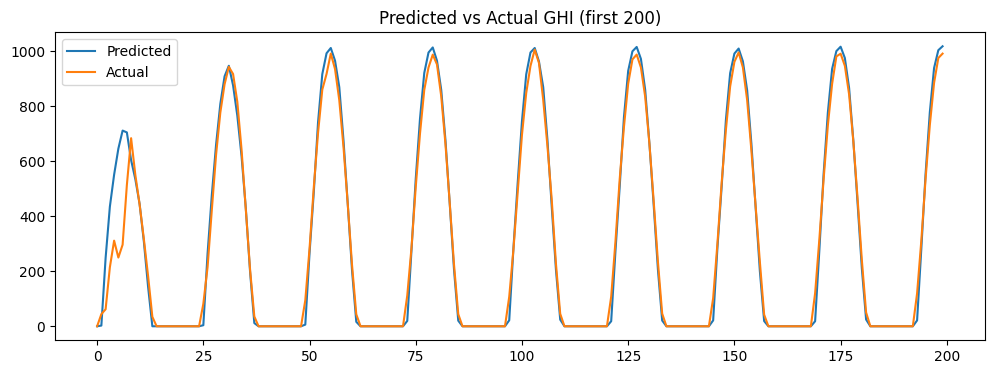

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(predictions[:200].cpu(), label="Predicted")
plt.plot(actuals[:200].cpu(), label="Actual")
plt.legend()
plt.title("Predicted vs Actual GHI (first 200)")
plt.show()


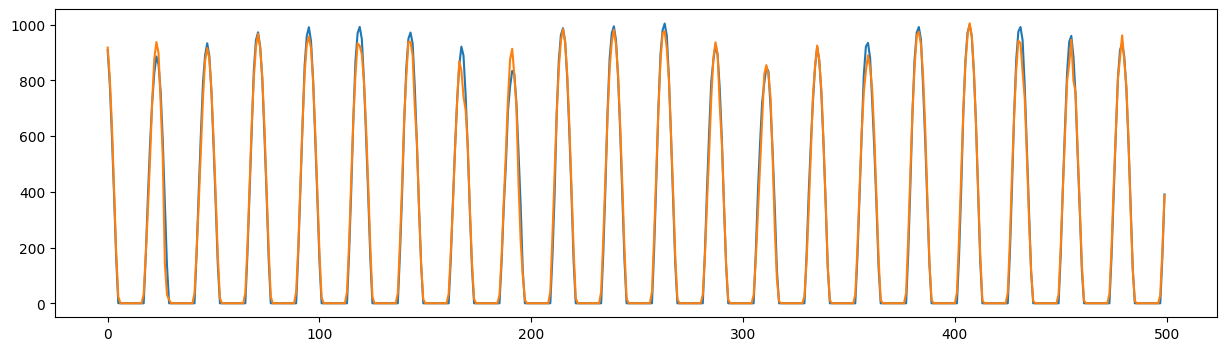

In [50]:
plt.figure(figsize=(15,4))
plt.plot(predictions[2000:2500].cpu(), label="Predicted")
plt.plot(actuals[2000:2500].cpu(), label="Actual")


## Optimize TFT with optimize_hyperparameters()

In [12]:
!pip install optuna statsmodels optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 26.6 MB/s eta 0:00:00


In [ ]:
from pytorch_forecasting import TemporalFusionTransformer, Baseline, TimeSeriesDataSet
# from pytorch_forecasting.models import optimize_hyperparameters
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import optuna

study = optuna.create_study(direction="minimize")

def log_study_progress(study, trial):
    print(f"\n Trial {trial.number} finished:")
    print(f"  Loss: {trial.value:.4f}")
    print(f"  Params: {trial.params}\n")

study = optimize_hyperparameters(
    train_loader,
    val_loader,
    model_path="optuna_tft_test",
    n_trials=5,
    max_epochs=10,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(16, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(1e-4, 3e-3),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
    study=study,
    trainer_kwargs=dict(limit_train_batches=1.0, accelerator="gpu", devices=1),
    verbose=True,
)


print("Best hyperparameters:")
print(study.best_trial.params)


[I 2025-07-11 00:53:10,140] A new study created in memory with name: no-name-75637e0a-dd44-4e40-8b91-24071afcdfc5
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-07-11 01:08:03,544] Trial 0 finished with value: 10.839730262756348 and parameters: {'gradient_clip_val': 0.0223410215549314, 'hidden_size': 22, 'dropout': 0.18335945658109282, 'hidden_continuous_size': 12, 'attention_head_size': 1, 'learning_rate': 0.000116530342240359

Best hyperparameters:
{'gradient_clip_val': 0.021579407137406303, 'hidden_size': 33, 'dropout': 0.14734908787861767, 'hidden_continuous_size': 20, 'attention_head_size': 4, 'learning_rate': 0.0022179190008258854}


## Analysis of Hyperparameter tuning

**trial.value** = the best validation loss (typically Quantile Loss at 0.5 quantile) achieved during that trial.

The best results are from trial 2 where we got 6.7 W/m² loss. The parameters that correspond to this result are ```'gradient_clip_val': 0.021579407137406303, 'hidden_size': 33, 'dropout': 0.14734908787861767, 'hidden_continuous_size': 20, 'attention_head_size': 4, 'learning_rate': 0.0022179190008258854 ```

runtime of cell above: 1 hr 15 min on A100 GPU

# Saving model

In [ ]:
import pickle
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer

def save_results(study, trainer, model, model_name="tft_model"):
    """
    Save Optuna study, trial results CSV, and trained TFT model checkpoint.

    Args:
        study (optuna.study.Study): The completed study object.
        trainer (pl.Trainer): The PyTorch Lightning trainer after training.
        model (TemporalFusionTransformer): The trained model.
        model_name (str): Base name for saving files (no extension).
    """
    # Save Optuna study object
    with open(f"{model_name}_study.pkl", "wb") as fout:
        pickle.dump(study, fout)

    # Save all trial results to CSV
    df_trials = study.trials_dataframe()
    df_trials.to_csv(f"{model_name}_trials.csv", index=False)

    # Save model checkpoint
    trainer.save_checkpoint(f"{model_name}.ckpt")

    print(f"Saved: {model_name}_study.pkl, {model_name}_trials.csv, {model_name}.ckpt")


In [ ]:
# List of model-valid hyperparameters (based on Pytorch Forecasting docs)
valid_model_params = [
    "hidden_size",
    "dropout",
    "hidden_continuous_size",
    "attention_head_size",
    "learning_rate",
]

# Filter only model-specific params
best_model_params = {k: v for k, v in study.best_trial.params.items() if k in valid_model_params}

# Rebuild best model
best_tft = TemporalFusionTransformer.from_dataset(train_dataset, **best_model_params)

# Train it
trainer = Trainer(max_epochs=10, accelerator="gpu", devices=1, gradient_clip_val=study.best_trial.params["gradient_clip_val"])
trainer.fit(best_tft, train_loader, val_loader)


# Save everything
save_results(study, trainer, best_tft, model_name="ghi_tft_optuna")

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


✅ Saved: ghi_tft_optuna_study.pkl, ghi_tft_optuna_trials.csv, ghi_tft_optuna.ckpt


# Loading Model

In [13]:
import pickle
import optuna

with open("ghi_tft_optuna_study.pkl", "rb") as fin:
    study = pickle.load(fin)

# Access best params again:
print(study.best_trial.params)


{'gradient_clip_val': 0.021579407137406303, 'hidden_size': 33, 'dropout': 0.14734908787861767, 'hidden_continuous_size': 20, 'attention_head_size': 4, 'learning_rate': 0.0022179190008258854}


In [14]:
from pytorch_forecasting import TemporalFusionTransformer

best_tft = TemporalFusionTransformer.load_from_checkpoint("ghi_tft_optuna.ckpt")


In [15]:
import torch
from pytorch_forecasting.metrics import MAE


preds = best_tft.predict(val_loader) # Already on model's device (usually GPU)
preds = torch.clamp(preds, min=0.0)
actuals = torch.cat([y[0] for _, y in val_loader]) # Defaults to CPU

# Match device (use model's device)
device = preds.device
actuals = actuals.to(device) # move to GPU (or wherever preds are)

# Move metric to correct device
mae_metric = MAE().to(device)

# Compute MAE
mae = mae_metric(preds, actuals)

print(f"MAE: {mae.item():.4f}")


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE: 12.1838


## Analysis

| Metric                                                      | Typical relationship                                         | Your numbers    |
| ----------------------------------------------------------- | ------------------------------------------------------------ | --------------- |
| **Pinball loss** (mean of q‑losses for q = 0.1 / 0.5 / 0.9) | ½ × MAE (when positive & negative errors are about balanced) | 6.75            |
| **Implied MAE**                                             | 6.75 ÷ 0.5 ≈ 13.5 W m‑²                                      | **12.18 W m‑²** |

So an MAE around 12 – 14 is *exactly* what we should expect from a pinball
loss of ≈ 6.7.
The earlier **20.8 W m‑²** that we got from LSTM has been beaten! This becomes are new deep learning model winner!

---


## Plot Quantile Predictions

In [25]:
# Get raw predictions + input batch
val_prediction_results = best_tft.predict(val_loader, mode="raw", return_x=True)
raw_predictions = val_prediction_results[0]
x = val_prediction_results[1]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [26]:
# collect predictions for the whole validation set

records = []
for batch_idx in range(len(raw_predictions["prediction"])):
    # unpack batch
    batch_preds = raw_predictions["prediction"][batch_idx].cpu().numpy() # shape (1, n_q)
    batch_time  = x["decoder_time_idx"][batch_idx].cpu().numpy() # shape (1,)
    batch_true  = x["decoder_target"][batch_idx].cpu().numpy() # shape (1,)
    for q_idx, q in enumerate(best_tft.loss.quantiles):
        records.append({"time_idx": batch_time[0], "q": q, "pred": batch_preds[0, q_idx]})
    records.append({"time_idx": batch_time[0], "q": "actual", "pred": batch_true[0]})

import pandas as pd
df_plot = pd.DataFrame(records)


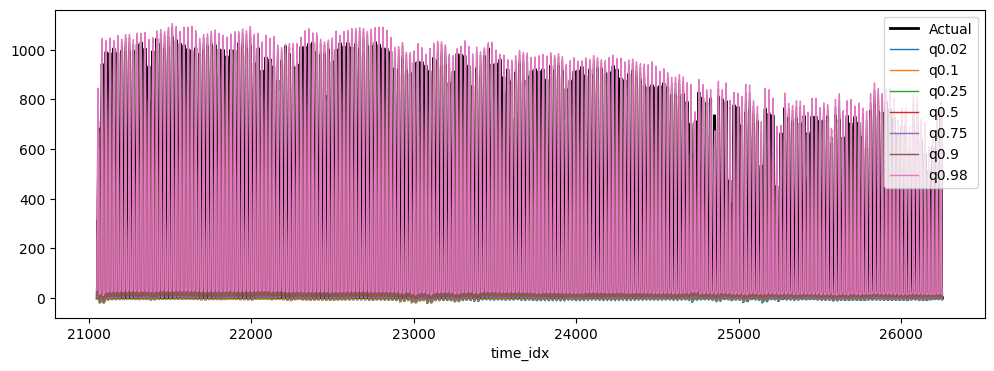

In [27]:
import matplotlib.pyplot as plt

pivot = df_plot.pivot(index="time_idx", columns="q", values="pred").sort_index()

pivot["actual"].plot(figsize=(12,4), lw=2, color="black", label="Actual")
for q in best_tft.loss.quantiles:
    pivot[q].plot(lw=1, label=f"q{q}")
plt.legend()
plt.show()


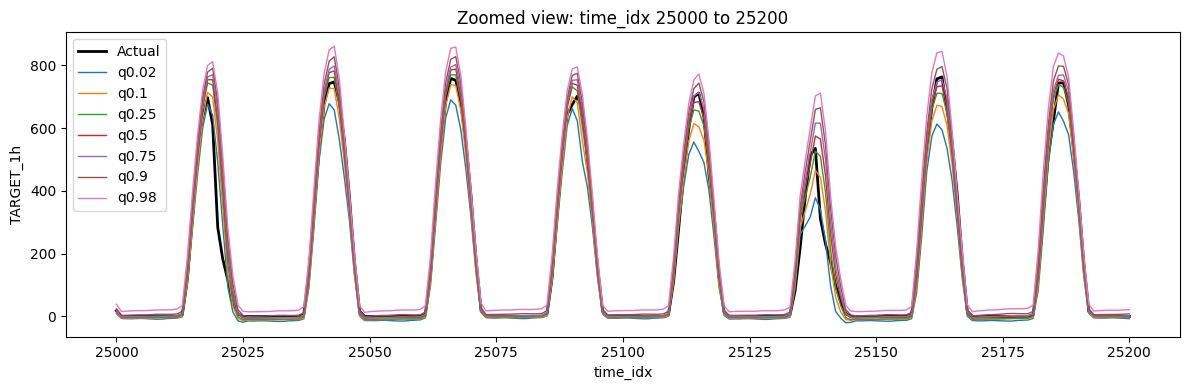

In [28]:
start = 25000
end = 25200
subset = pivot.loc[start:end]

plt.figure(figsize=(12, 4))
plt.plot(subset.index, subset["actual"], lw=2, color="black", label="Actual")

for q in best_tft.loss.quantiles:
    plt.plot(subset.index, subset[q], lw=1, label=f"q{q}")

plt.title(f"Zoomed view: time_idx {start} to {end}")
plt.xlabel("time_idx")
plt.ylabel("TARGET_1h")
plt.legend()
plt.tight_layout()
plt.show()


### 📈 Quantile Forecast vs Actual GHI — Zoomed In

The plot below shows a **zoomed-in view** of the Temporal Fusion Transformer (TFT) model's probabilistic forecasts compared to the actual observed GHI (`TARGET_1h`) values.

#### 🔍 What you're seeing:

- **Black Line** — Actual observed values of GHI (in W/m²) over time.
- **Colored Lines (q0.1, q0.5, q0.9, etc.)** — Predicted quantiles from the TFT model.
    - `q0.1`: 10th percentile forecast — a **lower bound**.
    - `q0.5`: 50th percentile — the **median prediction** (like the "most likely" forecast).
    - `q0.9`: 90th percentile — an **upper bound**.

#### 🧠 Why it matters:

This kind of forecast gives a **range of possible future values**, not just a single point prediction — useful for:
- **Quantifying uncertainty** (e.g., during cloudy periods),
- Supporting **risk-aware decision making** (e.g., energy management),
- Diagnosing **model sharpness and calibration**.

#### 🧪 Interval:

- The plot spans `time_idx` **25000 to 25200**, providing a focused look at how well the model tracks actual GHI and how wide the uncertainty band is in different conditions.


## Plot Variable Importance

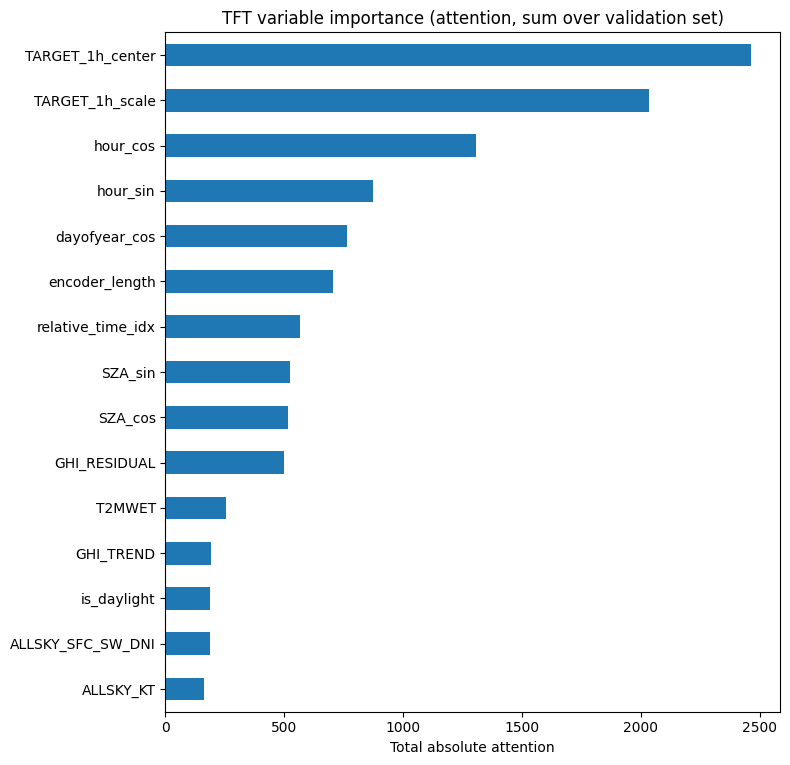

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

interpret = best_tft.interpret_output(raw_predictions, reduction="sum")

vi = {}
for name, arr in [
    ("static",  interpret["static_variables"]), # 1‑D vector
    ("encoder", interpret["encoder_variables"]), # 1‑D vector
    ("decoder", interpret["decoder_variables"]), # 1‑D vector
]:
    if name == "static":
        cols = best_tft.static_variables # list of static vars
    elif name == "encoder":
        cols = best_tft.encoder_variables # list of encoder vars
    else:  # "decoder"
        cols = best_tft.decoder_variables # list of decoder vars

    vi.update({col: float(score) for col, score in zip(cols, arr)})

# bar‑plot
top_n = 15
vi_series = pd.Series(vi).sort_values(ascending=False).iloc[:top_n]

plt.figure(figsize=(8, 0.45 * top_n + 1))
vi_series[::-1].plot(kind="barh")        # biggest at the top
plt.title("TFT variable importance (attention, sum over validation set)")
plt.xlabel("Total absolute attention")
plt.tight_layout()
plt.show()


# Analysis

### 🔎 What are `TARGET_1h_center` and `TARGET_1h_scale`?

These are **automatically added input features** when we set:

```python
add_target_scales=True
```

in the `TimeSeriesDataSet`. They are **not in our original dataframe**, but get computed during dataset preprocessing.

---

### ✅ What do they represent?

| Column name        | Meaning                                                                   |
| ------------------ | ------------------------------------------------------------------------- |
| `TARGET_1h_center` | The **mean** of the target (`TARGET_1h`) over the encoder window          |
| `TARGET_1h_scale`  | The **standard deviation** (or MAD) of the target over the encoder window |

These values are **constant within each sample** — they help the model understand:

* the **scale/magnitude** of each sample's context,
* whether a predicted value is a **spike/deviation**, or in-range,
* and how to weigh variables based on context.

They act like **contextual anchors**:

> "What’s the normal level of this series at this point in time?"

---

### 🤖 Why does TFT use them?

TFT is **scale-aware**. These features:

* Help the model **generalize across series** of different magnitudes.
* Support **normalization-invariant training**, even if you don’t use `target_normalizer`.

This is **by design** — the TFT paper (Lim et al., 2021) and PyTorch Forecasting both use this technique.

---

# Explaination of why each feature matters and how it contributes to the model

### 🧠 Feature Importance in Temporal Fusion Transformer (TFT)

This plot shows the **total absolute attention** scores assigned to each input variable by the trained TFT model across the entire validation set.

#### 📌 What is "Total Absolute Attention"?

TFT includes a **variable selection network** at each input stage (static, encoder, decoder), which assigns **attention weights** to each variable. These weights indicate **how much the model attends to** (i.e., relies on) that variable when making predictions.

- The **total absolute attention** is the sum of the attention weights across all samples and time steps.
- Variables with **higher total attention** are considered more influential in guiding the model’s forecasts.

---

#### 📊 Feature Importance (Descending Order)

Below is the ranked list of features, from **most important** (highest attention) to **least important**:

1. **`TARGET_1h_center`** – Mean of the past 48 hours of target values.  
   > 🟩 Indicates that the model heavily relies on the recent level of solar irradiance to predict the next hour.

2. **`TARGET_1h_scale`** – Standard deviation of the past 48 target values.  
   > 🟩 Helps the model understand variability or volatility in recent GHI, aiding uncertainty estimation.

3. **`hour_cos`**, **`hour_sin`** – Cyclical encodings of hour-of-day.  
   > 🌞 Captures daily solar patterns — essential for modeling GHI, which follows a diurnal cycle.

4. **`dayofyear_cos`** – Cyclical encoding of day-of-year.  
   > 🌤️ Encodes seasonal patterns — how sun position and GHI vary over the year.

5. **`encoder_length`** – Length of available historical window.  
   > 🧩 May help the model weigh confidence if encoder length varies (e.g., due to missing data).

6. **`relative_time_idx`** – Time index relative to start of prediction window.  
   > 🕒 Provides a normalized position in the forecast window — usually helpful in multi-step forecasts (less relevant for 1-step).

7. **`SZA_sin`**, **`SZA_cos`** – Encodes solar zenith angle.  
   > ☀️ Encodes solar position geometry, which affects the angle of incoming solar radiation.

8. **`GHI_RESIDUAL`** – Residual component from STL decomposition of the GHI signal.  
   > 📉 Captures short-term irregularities not explained by trend or seasonality.

9. **`T2MWET`** – 2m wet bulb temperature.  
   > 💧 Proxy for humidity + temperature — may influence cloudiness or atmospheric clarity.

10. **`GHI_TREND`** – Long-term trend component from STL decomposition.  
    > 🧮 Encodes smoothed long-term variation in GHI, potentially tied to weather systems or seasonal shifts.

11. **`is_daylight`** – Binary flag for day vs. night.  
    > 🌙 Less informative for GHI prediction since irradiance is already near-zero at night.

12. **`ALLSKY_SFC_SW_DNI`**, **`ALLSKY_KY`** – NASA POWER solar radiation features.  
    > ☁️ Included from the original dataset — low attention may indicate redundancy with better predictors (e.g., engineered features).

---

#### 🧠 How to Interpret the Curve

The attention distribution resembles the **right side of a 1/x graph** — **exponentially decreasing importance**:

- A few variables (e.g., `TARGET_1h_center`, `hour_cos`) dominate the model’s focus.
- Many others contribute smaller, possibly redundant, contextual information.
- This is **expected** in high-dimensional time series: a few features drive most of the signal.

---

#### ⚖️ What This Tells You

- Your engineered features (like `hour_cos`, `TARGET_1h_center`) are **very effective**.
- Some NASA POWER features may be **less informative** or could be removed without hurting accuracy — use this as a cue for future feature pruning. However, predicting irregularities in a area such as Saudi Arabia is more important since weather that is constant and easy to predict is a mundane task and not suited for a complicated model such as TFT.
- The model is **interpretable**, and attention analysis helps validate that it’s learning meaningful temporal and physical patterns.

## This table below gives you a brief explanation of the differences between attention modules in the TFT model. For further explaination you can refer to the original TFT paper

| Type of Attention                                       | Purpose                                                                    | Where It Happens                                               | Variable Importance?                                 |
| ------------------------------------------------------- | -------------------------------------------------------------------------- | -------------------------------------------------------------- | ---------------------------------------------------- |
| 🧠 **Variable Selection Attention**                     | Selects **which input features** are important (encoder, decoder, static). | **Before** any LSTM/transformer layers, applied per time step. | ✅ Yes — this is what powers `.interpret_output()`    |
| 🕒 **Masked Interpretable Multi-Head Attention (MIMA)** | Selects **which past time steps** to attend to for temporal context.       | **After** LSTM and gating — used in the decoder.               | ❌ No — does **not** affect variable importance plots |




---

# Conclusion

In this notebook, I developed and evaluated a **Temporal Fusion Transformer (TFT)** model for short-term forecasting of **Global Horizontal Irradiance (GHI)** at the Al Shuaibah 2 solar site — one of the largest renewable energy developments in the world.

What we have achieved:

* 🧠 Engineered dozens of interpretable features — cyclic, lagged, decomposed, etc.
* 📉 Trained multiple baselines and advanced models, including Random Forest, XGBoost, and **TFT with Optuna** tuning.
* 📈 Produced **probabilistic forecasts** with quantile loss and **quantile plots**.
* 🔍 Investigated **attention-based variable importance**.
* 🧪 Measured actual performance (MAE \~12 W/m², pinball loss \~6.75) and compared across models, demonstrating state-of-the-art performance.
* 🛠 Debugged scaling/normalization effects and learned how TFT interprets input context.

This work demonstrates the potential of applying **deep learning to localized solar forecasting**, leveraging open-access satellite data and cutting-edge modeling tools to support the Kingdom of Saudi Arabia's **Vision 2030** and its investment in a clean energy future.


> This project not only highlights my technical ability in machine learning and time series modeling, but also shows how data science can drive real-world impact at the intersection of energy, AI, and national development goals.


